## Midterm 2 :  Physics 403, S25
Aidan Meador-Woodruff (ameadorw@ur.rochester.edu)

Due: Friday April 4, 2025

In [1]:
# Import statements
import numpy as np
from matplotlib import pyplot as plt
import emcee
from scipy.integrate import nquad
from scipy.optimize import minimize
from scipy.stats import chi2, norm

### Problem 1 : Bump Hunting
An experiment searches for a new particle, the $X$ particle, with unknown mass $m_X$. The ex-
periment selects candidate events as a function of the measured mass. There is a background
that is known to be flat over the mass range of interest. Assume that any signal due to the $X$
particle has a Gaussian shape, but with unknown width. It is reasonable to assume that the
width is relatively narrow, not more than a few GeV. Neither the signal nor the background
rate is known a priori.

You may assume that there are no systematic uncertainties, and that the statistics are sufficiently high that the uncertainty on the number of counts in a bin is approximately
Gaussian with $\sigma = \sqrt{N}$ where $N$ is the number of counts.

Note that this problem is deliberately open-ended. You may use any reasonable analysis tech-
niques, and there are multiple correct approaches. You can earn full points as long as your
analysis and its interpretation is correct. The numerical answer that you get will likely de-
pend on the specific assumptions that you make, so it is possible that two different answers
could both be correct. It is critical that you state and justify the assumptions that you make.

Warning: It is possible that you will encounter calculations that take a long time (hours) to complete.

---

*a).* We wish to determine some measure of the significance of the signal using a Bayesian technique. We must justify any assumptions made and report an estimator of the mass $m_X$ and its uncertainty. We first visualize the data below

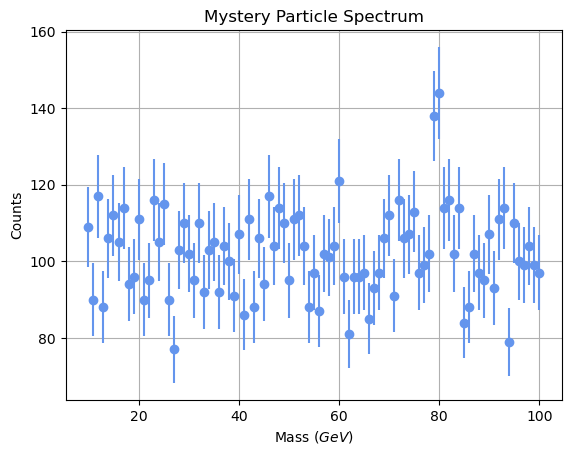

In [2]:
# Import the data and visualize it like a good physicist would.
data = np.loadtxt("bump_hunt.txt").transpose()
mass,counts = data

# Error is root N.
dy = np.sqrt(counts)

plt.errorbar(mass,counts,yerr=dy, fmt='o',color='cornflowerblue');
plt.xlabel(r'Mass $(GeV)$')
plt.ylabel(r'Counts')
plt.grid()
plt.title('Mystery Particle Spectrum');

It certainly looks like there's a particle to be found! For the Bayesian approach, I have decided to use an MCMC algorithm with `emcee`, as it will be pretty fast for the given dataset size. The first order of business is creating priors and the posterior for the MCMC simulation to actually run. I will produce both a model for a particle detection and a model for flat background noise, so that we can find the Bayes factor to determine which model is favored.

In [3]:
## Defining our models/priors/posteriors

def model(m,A,mu,sigma,B):
    """
    A model with a flat background and Gaussian signal.

    INPUTS :
    m - Masses to iterate over
    A - The scale of the signal
    mu - The centroid of the mass of the particle 
    sigma - The width of the peak
    B - The noise offset/background
    """
    return A * np.exp(-0.5 * ((m-mu)/sigma)**2) + B

def log_likelihood(theta, mass, counts):
    """
    Taking the log-likelihood of our model.

    INPUTS: 
    theta - The model parameters from above, m, A, mu, B
    mass - The data for the mass
    counts - The data for the counts
    """
    A, mu, sigma, B = theta
    model_counts = model(mass, A, mu, sigma, B)

    return -0.5 * np.sum(((counts - model_counts) / np.sqrt(counts)) ** 2)

def log_prior(theta):
    """
    Defining a flat prior. We restrict our parameters over a region and return a 
    slikelihood of zero outside of it  (to save computational resources, mostly).

    INPUTS: 
    theta - The model parameters from above, m, A, mu, B
    """
    A, mu, sigma, B = theta

    if 0 < A < 500 and 10 < mu < 100 and 0 < sigma < 10 and 50 < B < 150:
        return 0
    else:
        return -np.inf
    
def log_posterior(theta, mass, counts):
    """
    Finally, taking the log-posterior of our model for the MCMC.

    INPUTS: 
    theta - The model parameters from above, m, A, mu, B
    mass - The data for the mass
    counts - The data for the counts
    """

    lnprior = log_prior(theta)
    return lnprior + log_likelihood(theta, mass, counts)

## Flat models 

def flat_model(m,B):
    """
    Just what it says. It's a model that is flat.

    INPUTS : 
    m - Mass array (to match the size)
    B - Flat offset
    """
    return np.full_like(m, B)

def flat_log_likelihood(B, mass,counts):
    """
    Take the log likelihood of the flat model. 

    INPUTS : 
    mass - The data for the mass
    counts - The data for the counts
    B - Flat offset
    """
    
    model_counts = flat_model(mass, B)

    return -0.5 * np.sum(((counts - model_counts) / np.sqrt(counts)) ** 2)

def flat_log_prior(B):
    """
    Defining a flat prior for a flat model. We restrict our parameters over a region and return a 
    slikelihood of zero outside of it  (to save computational resources, mostly).

    INPUTS: 
    B - The model parameters from above, m, A, mu, B
    """
    if 50 < B < 150:
        return 0
    else:
        return -np.inf
    
def flat_log_posterior(B, mass, counts):
    """
    Finally, taking the log-posterior of our flat model for the MCMC.

    INPUTS: 
    B - The flat model offset.
    mass - The data for the mass
    counts - The data for the counts
    """

    lnprior = flat_log_prior(B)
    return lnprior + flat_log_likelihood(B, mass, counts)

Now that our model, likelihood, prior, and posterior are all cooked up, we want to initialize our MCMC simulation to use them. We have 4 parameters, so we will have 4 dimensions to seach over. I used the default number of walkers and steps in the `emcee` documentation and, in fact when I changed it, it seems ot converge to the same $m_X$ with the same errors, so that seems "super good enough." 


Of note and something I will use below, MCMC typically uses the 16-50-84 percentiles, which at first look a bit odd, but they are roughly $\mu - \sigma$, $\mu$, and $\mu + \sigma$, respectively, which allows us to extract appropraite error-bars (since a standard deviation is roughly $68\%$, half of this is $34\%$ and $34\%$ down or up from the mean ($50\%$) is $16\%$ or $84\%$).

In [4]:
## MCMC Parameters
ndim = 4 
nwalkers = 100  
nsteps = 10000  

## Initial guesses. From the data, we can see that the background is ~100, that the peak is about ~50 higher than that. mu is between 70 and 100, and sigma is pretty small.
initial = np.array([50, 50, 2, 100])

## We offset the walkers randomly around our guess
initial_pos = initial + 1e-4 * np.random.randn(nwalkers, ndim)

## Run MCMC
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(mass, counts))
sampler.run_mcmc(initial_pos, nsteps, progress=True)

## Extract parameters out of the sampler.
samples = sampler.get_chain(discard=100, thin=10, flat=True)
A_mcmc = np.percentile(samples[:, 0], [16, 50, 84])
mu_mcmc = np.percentile(samples[:, 1], [16, 50, 84])
sigma_mcmc = np.percentile(samples[:, 2], [16, 50, 84])
B_mcmc = np.percentile(samples[:, 3], [16, 50, 84])

## ------ Flat MCMC ------

ndim_flat = 1
# Initial guess for B
initial = 100 
initial_pos = initial + 1e-4 * np.random.randn(nwalkers, ndim_flat)
sampler_flat = emcee.EnsembleSampler(nwalkers, ndim_flat, flat_log_posterior, args=(mass, counts))
sampler_flat.run_mcmc(initial_pos, nsteps, progress=True)

## Extract parameters out of the sampler.
samples_flat = sampler_flat.get_chain(discard=100, thin=10, flat=True)
B_flat_mcmc = np.percentile(samples_flat[:, 0], [16, 50, 84])

100%|██████████| 10000/10000 [00:04<00:00, 2014.15it/s]


Now that the MCMC has run, we plot the results below.

Estimated mass (mX): 79.68 GeV
Uncertainty (1σ): +0.39 or -0.31 GeV


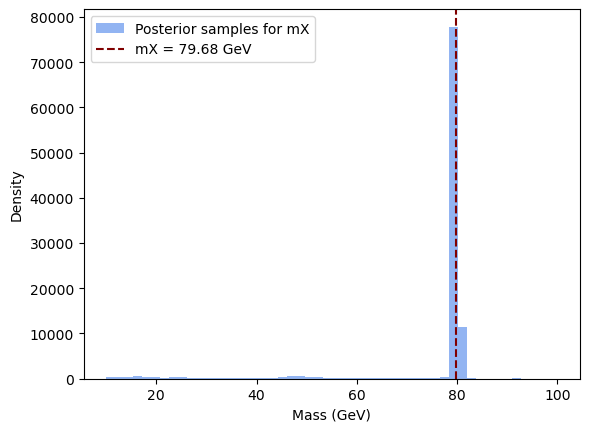

In [5]:
## Bayesian MCMC results 
print(f"Estimated mass (mX): {mu_mcmc[1]:.2f} GeV")
print(rf"Uncertainty (1σ): +{mu_mcmc[2] - mu_mcmc[1]:.2f} or -{mu_mcmc[1] - mu_mcmc[0]:.2f} GeV")
## Plots
plt.hist(samples[:,1], bins=50, alpha=0.7, color='cornflowerblue',label='Posterior samples for mX')
plt.axvline(mu_mcmc[1], color='maroon', linestyle='dashed', label=f'mX = {mu_mcmc[1]:.2f} GeV')
plt.xlabel("Mass (GeV)")
plt.ylabel("Density")
plt.legend();

Now, we plot the fit with these parameters agains the given particle data below.

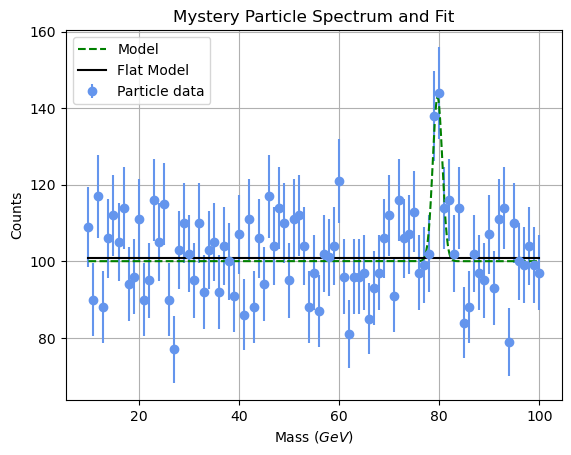

In [6]:
## For a smoother fit, make a linspace to iterate over
mass_cont = np.linspace(10,100,1000)
plt.errorbar(mass,counts,yerr=dy, fmt='o',color='cornflowerblue',label='Particle data');
plt.plot(mass_cont, model(mass_cont, A_mcmc[1], mu_mcmc[1], sigma_mcmc[1], B_mcmc[1]), label='Model', linestyle='dashed', color='green')
plt.plot(mass_cont, flat_model(mass_cont, B_flat_mcmc[1]), label='Flat Model', color='k')
plt.xlabel(r'Mass $(GeV)$')
plt.ylabel(r'Counts')
plt.grid()
plt.legend()
plt.title('Mystery Particle Spectrum and Fit');

That looks like a pretty decent fix to our bump. Now, we find the Bayes factor between the flat model and the model that expects a particle. This reduces to the ratio of the probabilities of each model. I will use the average of the probabilities of my MCMC chains. While this is probably not the most rigorous way of doing this, since we already have the chains burned in, it is much faster than doing a 4-dimensional phase space integral over our parameters ($A, B, \mu, \sigma$). `emcee` has a built-in method to return the log probabiltiies, which I just averaged and exponentiated for both models. In reality, we could also find the PDF of each model, take our best fit MCMC parameters, and integrate over it, but I decided not to do it this way.

In [7]:
## Grab log probabilities from emcee and find the normalization
lnp_flat = sampler_flat.get_log_prob(flat=True)
lnp_gaussian = sampler.get_log_prob(flat=True)
normal = np.mean(np.exp(lnp_gaussian)) + np.mean(np.exp(lnp_flat))

## Exponentiate and normalize
gaussian_P = np.mean(np.exp(lnp_gaussian))/normal
flat_P = np.mean(np.exp(lnp_flat))/normal
Bf = gaussian_P/flat_P

print(f'The probability of the 4 parameter model compared to the null hypothesis (just background) is {(gaussian_P)*100:0.6g}%.')
print(f'The probability of the null hypothesis is {(flat_P)*100:0.4f}%.')
print(f'This model has a Bayes factor of {gaussian_P/flat_P:1.1f}')

The probability of the 4 parameter model compared to the null hypothesis (just background) is 99.9986%.
The probability of the null hypothesis is 0.0014%.
This model has a Bayes factor of 71357.8


A very huge Bayes factor indicates statistical significance. We will see later that this probability agrees with the frequentist approach.

*b).* We wish to determine some level of significance of the signal using a frequentist technique. We will do this quantitatively with respect to the model of only the background, and report an estimator $m_X$ with an uncertainty. I will use the $\chi^2$ test. We will use the same models as above, so no need to redefine them. First, I will define the $\chi^2$ functions.

In [8]:
## Defining our chi^2s

def chi2_signal(params):
    """ 
    The chi^2 for the signal.
    
    INPUTS:
    params = [A, mu, sigma, B]
    ---
    A - The height of the Gaussian
    mu - The centroid of the mass
    sigma - The width of the peak
    B - The constant offset
    """
    A, mu, sigma, B = params
    model_counts = model(mass, A, mu, sigma, B)
    return np.sum(((counts - model_counts)/dy)**2)


def chi2_bg(B):
    """ 
    The chi^2 for the flat/background model.

    INPUTS:
    B - The constant offset
    """
    model_counts = flat_model(mass,B)
    return np.sum(((counts - model_counts)/dy)**2)

Now, we wish to minimize both of these.

In [9]:
## Minimize the background/flat chi^2 with an initial guess of B=100 (by inspection).
result_bg = minimize(chi2_bg, [100])
chi2_min_bg = result_bg.fun

## Minimize the actual expected chi^2 with the same initial guesses as before.
initial_guess = [50, 80, 2, 100] 
result_signal = minimize(chi2_signal, initial_guess, bounds=[(0, 1000), (60, 100), (0.1, 10), (50, 150)])
chi2_min_signal = result_signal.fun

## Find Delta chi^2
delta_chi2 = chi2_min_bg - chi2_min_signal

## Finding p-value by Wilk's theorem.
dof = 3 # 4-1 = 3 (A,mu,sigma,B in true fit, only B in flat)
p_value = chi2.sf(delta_chi2, dof)
significance = norm.ppf(1 - p_value / 2) # Just to get the p-value in sigma

Now, we plot the results below.

Delta Chi^2: 24.95
p-value: 1.58e-05
Significance 4.32 sigma
Best-fit mX: 79.70 GeV ± 0.86 GeV


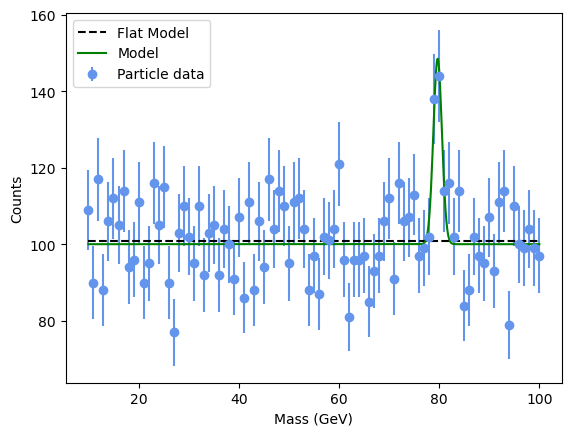

In [10]:
## Results
print(f"Delta Chi^2: {delta_chi2:.2f}")
print(f"p-value: {p_value:.3g}")
print(f"Significance {significance:.2f} sigma")
best_mX = result_signal.x[1]
best_sigma = result_signal.x[2]
print(f"Best-fit mX: {best_mX:.2f} GeV ± {best_sigma:.2f} GeV")

## Plotting
plt.errorbar(mass,counts,yerr=dy, fmt='o',color='cornflowerblue',label='Particle data');
plt.plot(mass_cont, flat_model(mass_cont, result_bg.x[0]), label='Flat Model', linestyle='--',color='k')
plt.plot(mass_cont, model(mass_cont, *result_signal.x), label='Model',color='green')
plt.xlabel("Mass (GeV)")
plt.ylabel("Counts")
plt.legend();

Our best fit finds roughly the same mass for $m_X$ as the Bayesian approach. This $p$-value is actually  roughly the same as our Bayesian approach also (the probability of the null hypothesis).

*c).* Both our Bayesian and frequentist results indicate that we have perhaps discovered the $X$ particle and our $p$-value indicates a statistically-significant result; With a probability of about $1.5\times 10^{-5}$, we expect our outcome to be a background fluctuation, which corresponds to a nearly 4.5 sigma effect.

**However** this does **not** meet the 5 sigma threshold of significance. If this were a real experiment, we would not be able to confidently claim to have found our particle, but it would be an indication it may exist. We should collect more data or, if we wished to do more statistics, do many more MCMCs (or the Feldman-Cousins and just model the null hypothesis, if you are a frequentist). This, however, would be reasonably computationally expensive. Perhaps if you had big DOE dollars, you could convince your local friend with a super computer that it would be worth their while to simulate, which would probably be significantly faster than my laptop.
